In [19]:
import mne
import glob
import os
import scipy.io
from scipy.spatial.distance import cosine
import numpy as np
from pymatreader import read_mat
import matplotlib as plt
#import pandas as pd
#import rsatoolbox


In [ ]:
fname = "/Users/denisekittelmann/Documents/MATLAB/Hannah_data/EEG/P02/eTadffspmeeg_1.mat"
data = read_mat(fname) # ["fD"]
data.keys()
#data["fD"].keys()

data["D"].keys()

#data["D"]["condlist"]
#data["D"]["trials"].keys() #['label']
#data["D"]["trials"]["tag"]
#data["D"]["condlist"] # leer
#data["D"]["history"].keys()
data["D"]["trials"]['label']

''' 
mapping condition label "leading_library" to condition code 1
mapping condition label "trailing_conference_room" to condition code 2
mapping condition label "leading_restaurant" to condition code 3
mapping condition label "leading_Barn" to condition code 4
mapping condition label "trailing_church" to condition code 5
mapping condition label "leading_beach" to condition code 6
mapping condition label "leading_cave" to condition code 7
mapping condition label "trailing_forest" to condition code 8
mapping condition label "trailing_castle" to condition code 9

'''


['leading_library',
 'trailing_conference_room',
 'leading_restaurant',
 'trailing_conference_room',
 'leading_Barn',
 'trailing_church',
 'leading_beach',
 'trailing_church',
 'leading_cave',
 'trailing_forest',
 'leading_cave',
 'trailing_forest',
 'leading_cave',
 'trailing_forest',
 'leading_cave',
 'trailing_castle',
 'leading_beach',
 'trailing_church',
 'leading_Barn',
 'trailing_conference_room',
 'leading_beach',
 'trailing_church',
 'leading_library',
 'trailing_conference_room',
 'leading_beach',
 'trailing_church',
 'leading_cave',
 'trailing_forest',
 'leading_beach',
 'trailing_church',
 'leading_library',
 'trailing_conference_room',
 'leading_library',
 'trailing_conference_room',
 'leading_library',
 'trailing_conference_room',
 'leading_restaurant',
 'trailing_conference_room',
 'leading_restaurant',
 'trailing_conference_room',
 'leading_beach',
 'trailing_church',
 'leading_cave',
 'trailing_castle',
 'leading_cave',
 'trailing_castle',
 'leading_cave',
 'trailing_f

Not setting metadata
3456 matching events found
No baseline correction applied
0 projection items activated


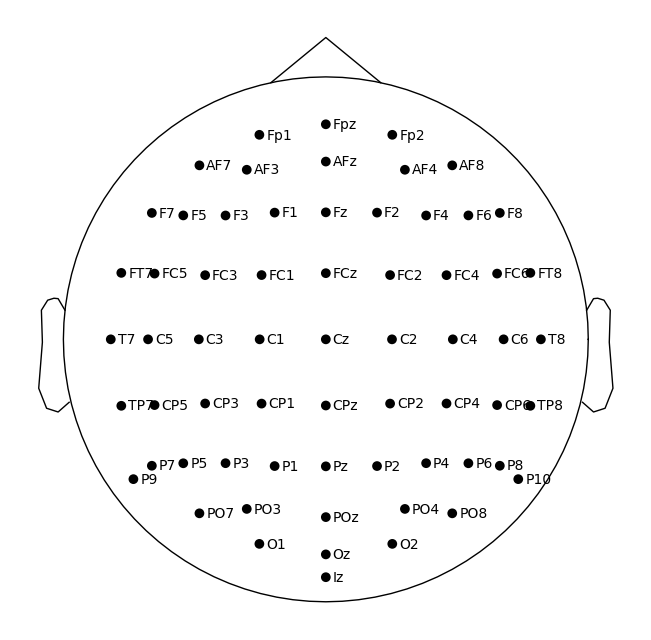

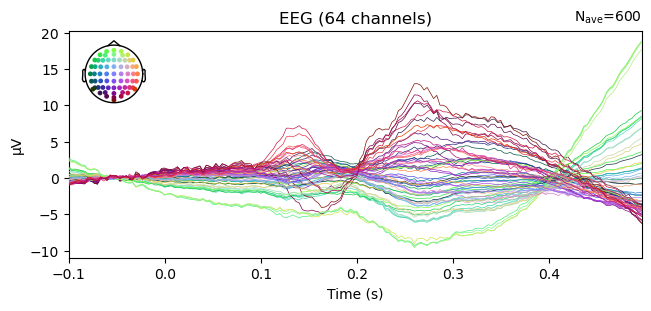

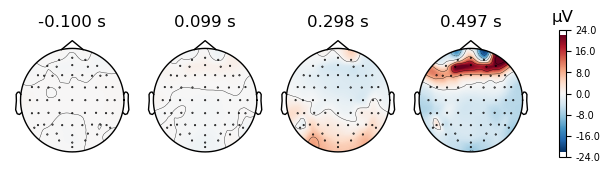

In [58]:
################################ LOAD DATA ################################ 

# Load the FieldTrip .mat file
fname = "/Users/denisekittelmann/Documents/Python/BiMoL/data/EEG/eTadff_sub01.mat"
data = read_mat(fname)["fD"]

# read the fields that we will need later
epochs_data = np.array(data["trial"]) * 1e-6 # the mat file says the unit is V, but I think it's actually muV
tmin = data['time'][0][0]
sfreq = int(1. / (data['time'][0][1] - tmin))
ch_names = data["label"]
ch_types = data["elec"]["chantype"]
montage = mne.channels.make_standard_montage("biosemi64", head_size=0.095)  # we could read the ch locations from file, but here we just read the cap used in the experiment
event_dict = {
    "leading_library": 1,
    "trailing_conference_room": 2,
    "leading_restaurant": 3,
    "leading_barn": 4,
    "trailing_church": 5,
    "leading_beach": 6,
    "leading_cave": 7,
    "trailing_forest": 8,
    "trailing_castle": 9
}
event_id = list(data["trialinfo"])
events = np.stack([np.arange(len(event_id)),
                   np.zeros_like(event_id), 
                   event_id], axis=1)
# event_dict <- this will be a useful parameter to set, but we'll need to know what numbers stand for what condition


# create the info field
info = mne.create_info(ch_names=ch_names, sfreq=sfreq, ch_types=ch_types)

# Create an MNE Epochs object
epochs = mne.EpochsArray(data=epochs_data, info=info, tmin=tmin,
                         events=events, event_id=event_dict) 

# set the montage for correct channel positions
epochs = epochs.set_montage(montage)

# plot different events to check if everything sits right
epochs.plot_sensors(show_names=True);
epochs["trailing_church"].average().plot();
epochs["leading_restaurant"].average().plot_topomap();

In [ ]:
def read_custom_epochs(fname):
    # Read .mat file and extract required data
    data = read_mat(fname)["fD"]

    # Extract and process relevant fields
    epochs_data = np.array(data["trial"]) * 1e-6  # Assuming data is in muV
    tmin = data['time'][0][0]
    sfreq = int(1. / (data['time'][0][1] - tmin))
    ch_names = data["label"]
    ch_types = data["elec"]["chantype"]
    montage = mne.channels.make_standard_montage("biosemi64", head_size=0.095)
    
    # Extract event information
    event_id = list(data["trialinfo"]) # categories 1-9 -> where to find the mapping? 
    events = np.stack([np.arange(len(event_id)),
                       np.zeros_like(event_id), 
                       event_id], axis=1)

    # Create the MNE Info object
    info = mne.create_info(ch_names=ch_names, sfreq=sfreq, ch_types=ch_types)

    # Create the MNE Epochs object
    epochs = mne.EpochsArray(data=epochs_data, info=info, tmin=tmin,
                             events=events, event_id=event_id)

    # Set the montage for channel positions
    epochs = epochs.set_montage(montage)

    # Plot to verify
    #epochs.plot_sensors(show_names=True)
    #epochs["5"].average().plot()
    #epochs["leading_restaurant"].average().plot_topomap()

    return epochs

In [ ]:
################################ COMPUTE EEG RDM ################################ 

from scipy.spatial.distance import cosine
import matplotlib.pyplot as plt

dir = "/Users/denisekittelmann/Documents/Python/BiMoL/data/EEG/eTadff_sub{}_*.mat"

id = range(1,31)
rdm_per_sid = []

# compute EEG RDMs for each participant 
for i in range(id):  
    file_path = dir.format(i)
    for fname in glob.glob(file_path):
        
        data = read_mat(fname)["fD"]
        
        read_custom_epochs(fname)
        
        rdm = np.zeros([9, 9])
        for i in range(1, 10):
            for j in range(1, 10):
                arr_1 = epochs[str(i)].average().get_data().reshape(-1)
                arr_2 = epochs[str(j)].average().get_data().reshape(-1)
                rdm[i-1, j-1] = cosine(arr_1, arr_2)
        plt.imshow(rdm)
        plt.colorbar()
        

In [ ]:
################################ COMPUTE ANN RDMs ################################ 

dir_pcn = "/Users/denisekittelmann/Documents/Python/BiMoL/results/pcn/final_model_pcn_lr1e-7_trained.keras"
dir_bpann = "/Users/denisekittelmann/Documents/Python/BiMoL/results/bp_ann/final_model_bp_lr1e-7_trained.keras"

# ToDo add best model 
# look at validation performance -> min (max (from validation accuracy history_pcn), max (from validation accuracy history_bp))
# zeitvisucheckend -schick dirk visually alllich 

# Load the model
pcn = tf.keras.models.load_model(dir_pcn)
bp_ann = tf.keras.models.load_model(dir_bpann)

# Create dict to map labels stimulus categories

cat_dict = {1: (0, 1),
            2: (0, 2)
            }

def batch_drawing_function(valid_cat):
  # add the drwaing according to the mapping
  # 35 leading
  # 45 trailing 
  

rdm_h1_pcn = np.zeros([9, 9])
rdm_h1_bp = np.zeros([9, 9])
rdm_h2 = np.zeros([9, 9])
rdm_h3 =np.zeros([9, 9])

for category_i in cat_dict:
  for category_j in cat_dict: 

    batch_i = batch_drawing_function(category_i)
    pcn_acts_i = pcn(batch_i)

    batch_j = batch_drawing_function(category_j)
    pcn_acts_j = pcn(batch_j)
    
    batch_i = batch_drawing_function(category_i)
    bp_acts_i = bp_ann(batch_i)

    batch_j = batch_drawing_function(category_j)
    bp_acts_j = bp_ann(batch_j)
    
    
        # H1
    rdm_h1_pcn[i, j] = cosine(np.mean(pcn_acts_i[0], axis=0), np.mean(pcn_acts_j[0], axis=0))
    rdm_h1_bp[i, j] = cosine(np.mean(bp_acts_i[1], axis=0), np.mean(bp_acts_j[1], axis=0))
    
      # H2 &H3
    rdm_h1_pcn[i, j] = cosine(np.mean(np.concatenate([layer for layer in pcn_acts_i], axis=1), axis=0), np.mean(np.concatenate([layer for layer in pcn_acts_j], axis=1), axis=0))
    rdm_h1_bp[i, j] = cosine(np.mean(np.concatenate([layer for layer in bp_acts_i], axis=1), axis=0), np.mean(np.concatenate([layer for layer in bp_acts_j], axis=1), axis=0)) 

plt.imshow(rdm)
plt.colorbar()



In [ ]:
################################ COMPUTE SIMILARITY BETWEEN RDMs ################################ 

# Spearman’s rank correlation -> pearson 

In [ ]:
################################ STATISTICALLY TEST SIMILARITIES ################################ 

# non parametric test: permutation test? -> nur replicable with z scoring 





In [ ]:
fname = "/Users/denisekittelmann/Documents/Python/BiMoL/data/EEG/eTadff_sub01.mat"
data = read_mat(fname)
data.keys()
data["fD"].keys()

#data["fD"]["label"] # channel names
#data["fD"]["trial"] # samples
data["fD"]["trialinfo"] # numbers from 1-9 -> potentially the different categories 
#data["fD"]["elec"]


array([1, 2, 3, ..., 5, 4, 2], dtype=uint8)

In [54]:
epochs.event_id

{'1': 1, '2': 2, '3': 3, '4': 4, '5': 5, '6': 6, '7': 7, '8': 8, '9': 9}

In [59]:
################################ TEST FOR INE PARTICIPANT################################ 

from scipy.spatial.distance import cosine
import matplotlib.pyplot as plt

# EEG RDM 

rdm = np.zeros([9, 9])
for i in range(1, 10):
  for j in range(1, 10):
    arr_1 = epochs[str(i)].average().get_data().reshape(-1)
    arr_2 = epochs[str(j)].average().get_data().reshape(-1)
    rdm[i-1, j-1] = cosine(arr_1, arr_2)



# convert correction to z test on sample t-test 
# pearson correlation correlations to z score  ->  at the group level; fishers rank correlation parametric way more producible 
# standard fehler sample size  -> alle einträge in der der matrix -> 9 X 9 
# 

plt.imshow(rdm)
plt.colorbar()



# scipy rank correclatiion  before flatten

KeyError: 'Event name "1" could not be found. The following events are present in the data: leading_library, trailing_conference_room, leading_restaurant, leading_barn, trailing_church, leading_beach, leading_cave, trailing_forest, trailing_castle'

([<matplotlib.axis.YTick at 0x1645ec390>,
 [Text(0, 0, '1'),
  Text(0, 1, '2'),
  Text(0, 2, '3'),
  Text(0, 3, '4'),
  Text(0, 4, '5'),
  Text(0, 5, '6'),
  Text(0, 6, '7'),
  Text(0, 7, '8'),
  Text(0, 8, '9')])

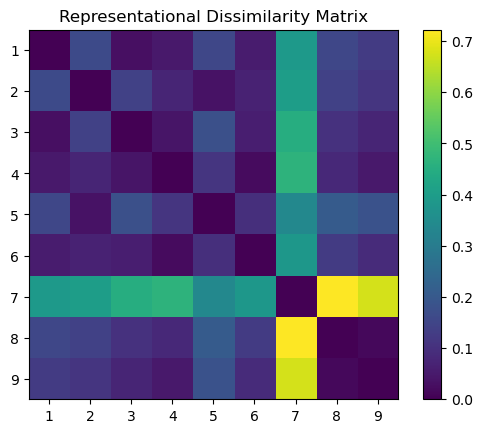

In [ ]:
from scipy.spatial.distance import cosine
import matplotlib.pyplot as plt

# EEG RDM 

n_events = len(event_dict)
rdm = np.zeros((n_events, n_events))

# List of event names from the event_dict for indexing
event_names = list(event_dict.keys())

# Iterate over event names
for i, event_name_i in enumerate(event_names):
    for j, event_name_j in enumerate(event_names):
        arr_1 = epochs[event_name_i].average().get_data().reshape(-1)
        arr_2 = epochs[event_name_j].average().get_data().reshape(-1)
        rdm[i, j] = cosine(arr_1, arr_2)

# Plot the RDM matrix
plt.imshow(rdm, cmap="viridis")
plt.colorbar()

# Set custom tick labels from 1 to 9 for both x and y axes
plt.xticks(ticks=np.arange(n_events), labels=np.arange(1, n_events + 1))
plt.yticks(ticks=np.arange(n_events), labels=np.arange(1, n_events + 1))


# convert correction to z test on sample t-test 
# pearson correlation correlations to z score  ->  at the group level; fishers rank correlation parametric way more producible 
# standard fehler sample size  -> alle einträge in der der matrix -> 9 X 9 
# 


    "leading_library": 1,
    "trailing_conference_room": 2,
    "leading_restaurant": 3,
    "leading_barn": 4,
    "trailing_church": 5,
    "leading_beach": 6,
    "leading_cave": 7,
    "trailing_forest": 8,
    "trailing_castle": 9


  legal_pairs = {{'leading_Barn' 'trailing_church'} ... % valid 75%
                {'leading_Barn' 'trailing_conference_room'} ... % invalid 25%
                {'leading_beach' 'trailing_church'} ... % valid 75%
                {'leading_beach' 'trailing_conference_room'} ... % invalid 25%
                {'leading_library' 'trailing_conference_room'} ... % valid 75%
                {'leading_library' 'trailing_church'} ... % invalid 25%
                {'leading_restaurant' 'trailing_conference_room'} ... % valid 75%
                {'leading_restaurant' 'trailing_church'} ... % invalid 25%
                {'leading_cave' 'trailing_castle'} ... % control 50%
                {'leading_cave' 'trailing_forest'}}; % control 50%

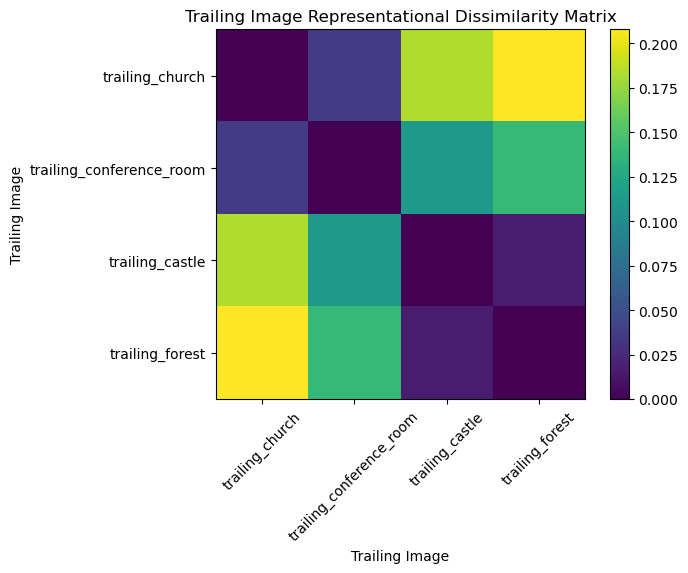

In [67]:
trailing_images = ['trailing_church', 'trailing_conference_room', 'trailing_castle', 'trailing_forest']

n_trailing = len(trailing_images)
trailing_rdm = np.zeros((n_trailing, n_trailing))

# Calculate the RDM for trailing images
for i, trail_i in enumerate(trailing_images):
    for j, trail_j in enumerate(trailing_images):
        # Extract the average EEG response for each trailing image condition
        arr_1 = epochs[trail_i].average().get_data().reshape(-1)  # Average EEG data for trail_i
        arr_2 = epochs[trail_j].average().get_data().reshape(-1)  # Average EEG data for trail_j
        
        # Compute cosine dissimilarity between the two average signals
        trailing_rdm[i, j] = cosine(arr_1, arr_2)

# Plot the trailing RDM
plt.imshow(trailing_rdm, cmap='viridis')
plt.colorbar()
plt.title('Trailing Image Representational Dissimilarity Matrix')
plt.xlabel('Trailing Image')
plt.ylabel('Trailing Image')
plt.xticks(ticks=np.arange(n_trailing), labels=trailing_images, rotation=45)
plt.yticks(ticks=np.arange(n_trailing), labels=trailing_images)
plt.show()


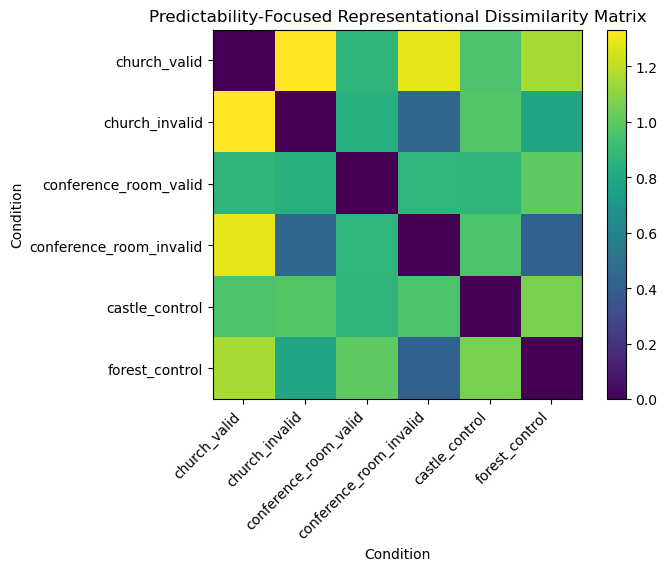

In [68]:
import numpy as np
from scipy.spatial.distance import cosine
import matplotlib.pyplot as plt

# Define the event dictionary for each leading-trailing pair
event_dict = {
    'leading_Barn_trailing_church': 1,
    'leading_Barn_trailing_conference_room': 2,
    'leading_beach_trailing_church': 3,
    'leading_beach_trailing_conference_room': 4,
    'leading_library_trailing_conference_room': 5,
    'leading_library_trailing_church': 6,
    'leading_restaurant_trailing_conference_room': 7,
    'leading_restaurant_trailing_church': 8,
    'leading_cave_trailing_castle': 9,
    'leading_cave_trailing_forest': 10
}

# Define valid, invalid, and control pairs
valid_pairs = {
    'trailing_church': ['leading_Barn_trailing_church', 'leading_beach_trailing_church'],
    'trailing_conference_room': ['leading_library_trailing_conference_room', 'leading_restaurant_trailing_conference_room']
}

invalid_pairs = {
    'trailing_church': ['leading_library_trailing_church', 'leading_restaurant_trailing_church'],
    'trailing_conference_room': ['leading_Barn_trailing_conference_room', 'leading_beach_trailing_conference_room']
}

control_pairs = {
    'trailing_castle': ['leading_cave_trailing_castle'],
    'trailing_forest': ['leading_cave_trailing_forest']
}

# Find event IDs for valid, invalid, and control contexts for each trailing image
valid_church_ids = [event_dict[pair] for pair in valid_pairs['trailing_church']]
invalid_church_ids = [event_dict[pair] for pair in invalid_pairs['trailing_church']]

valid_conference_room_ids = [event_dict[pair] for pair in valid_pairs['trailing_conference_room']]
invalid_conference_room_ids = [event_dict[pair] for pair in invalid_pairs['trailing_conference_room']]

control_castle_ids = [event_dict[pair] for pair in control_pairs['trailing_castle']]
control_forest_ids = [event_dict[pair] for pair in control_pairs['trailing_forest']]

# Extract epochs for each condition
church_valid_epochs = epochs[valid_church_ids].average().get_data().reshape(-1)
church_invalid_epochs = epochs[invalid_church_ids].average().get_data().reshape(-1)

conference_room_valid_epochs = epochs[valid_conference_room_ids].average().get_data().reshape(-1)
conference_room_invalid_epochs = epochs[invalid_conference_room_ids].average().get_data().reshape(-1)

castle_control_epochs = epochs[control_castle_ids].average().get_data().reshape(-1)
forest_control_epochs = epochs[control_forest_ids].average().get_data().reshape(-1)

# Define all conditions for the RDM
conditions = [
    'church_valid', 'church_invalid',
    'conference_room_valid', 'conference_room_invalid',
    'castle_control', 'forest_control'
]

# Prepare data for each condition
data_dict = {
    'church_valid': church_valid_epochs,
    'church_invalid': church_invalid_epochs,
    'conference_room_valid': conference_room_valid_epochs,
    'conference_room_invalid': conference_room_invalid_epochs,
    'castle_control': castle_control_epochs,
    'forest_control': forest_control_epochs
}

# Initialize the RDM
n_conditions = len(conditions)
rdm = np.zeros((n_conditions, n_conditions))

# Populate the RDM with cosine dissimilarity between each condition
for i, cond_i in enumerate(conditions):
    for j, cond_j in enumerate(conditions):
        rdm[i, j] = cosine(data_dict[cond_i], data_dict[cond_j])

# Plot the RDM
plt.imshow(rdm, cmap='viridis')
plt.colorbar()
plt.title('Predictability-Focused Representational Dissimilarity Matrix')
plt.xlabel('Condition')
plt.ylabel('Condition')
plt.xticks(ticks=np.arange(n_conditions), labels=conditions, rotation=45, ha='right')
plt.yticks(ticks=np.arange(n_conditions), labels=conditions)
plt.show()


In [ ]:


#Map 1 = C1 LEADING >> C6 TRAILING valid, C7 invalid 4 -> 5 = valid; 4 -> 2 = unvalid 
#Map 2 = C2 LEADING >> C6 TRAILING valid, C7 invalid 6 -> 5 = valid; 6 -> 2 = invalid 
#Map 3 = C4 LEADING >> C7 TRAILING valid, C6 invalid 1 -> 2 = valid; 1 -> 5 = invalid 
#Map 4 = C5 LEADING >> C7 TRAILING valid, C6 invalid 3 -> 2 = valid; 3 -> 5 = invalid 
#Map 5 = C3 LEADING >> C8 OR C9 TRAILING    7 -> 9 or 8 
#Map 6 = C3 LEADING >> C9 OR C9 TRAILING    7 -> 9 or 8 
    
    
    
    
    "leading_library": 1,

    "leading_restaurant": 3,
    "leading_barn": 4, 

    "leading_beach": 6,
    "leading_cave": 7,
    
    "trailing_conference_room": 2,
    "trailing_church": 5,
    "trailing_forest": 8,
    "trailing_castle": 9
    
    
    'Cat1', barn'; 4
    'Cat2', 'beach'; 6
    'Cat3', 'cave'; 7
    'Cat4', 'library'; 1
    'Cat5', 'restaurant'; 3
    'Cat6', 'Church'; 5
    'Cat7', 'conference_room'; 2
    'Cat8', 'castle'; 9
    'Cat9', 'forest'   8
    
#Map 1 = C1 LEADING >> C6 TRAILING valid, C7 invalid 4 -> 5 = valid; 4 -> 2 = unvalid 
#Map 2 = C2 LEADING >> C6 TRAILING valid, C7 invalid 6 -> 5 = valid; 6 -> 2 = invalid 
#Map 3 = C4 LEADING >> C7 TRAILING valid, C6 invalid 1 -> 2 = valid; 1 -> 5 = invalid 
#Map 4 = C5 LEADING >> C7 TRAILING valid, C6 invalid 3 -> 2 = valid; 3 -> 5 = invalid 
#Map 5 = C3 LEADING >> C8 OR C9 TRAILING    7 -> 9 or 8 
#Map 6 = C3 LEADING >> C9 OR C9 TRAILING    7 -> 9 or 8 
    
    


